In [1]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import pickle
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Define functions, load data

## 1.1. Import interactive maps module

In [2]:
import geopandas as gpd
import folium
from folium import Choropleth, Circle, Marker
from folium.plugins import HeatMap, MarkerCluster

In [3]:
# Function for displaying the map

def embed_map(m, file_name):
    from IPython.display import IFrame
    m.save(file_name)
    return IFrame(file_name, width='100%', height='500px')

## 1.2. Define functions for calculating distance on Earth

In [4]:
# Using geopy
import geopy.distance

def dist(a, b):
    return geopy.distance.geodesic((a.x, a.y), (b.x, b.y)).km

In [5]:
# Using geopandas
def dist_2(a, b):
    a = gpd.GeoSeries(Point(a.y, a.x), crs=({"init":"epsg:4326"})).to_crs(epsg=3310)
    b = gpd.GeoSeries(Point(b.y, b.x), crs=({"init":"epsg:4326"})).to_crs(epsg=3310)
    return a.distance(b) / 1000

## 1.3. Load DataFrames for `apartaments` and `metro`

In [6]:
apartaments = pd.read_csv("apartaments.csv")
metro = pd.read_csv("metro.csv")

# 2. Prepare data

## 2.1. Add `price` to `rental price` in order to get `real price`

In [7]:
# Function to check if value is Nan or not
def notNan(a):
    return a == a

In [8]:
def real_price(row):
    if notNan(row['Czynsz - dodatkowo']):
        return int(row['Cena']) + int(row['Czynsz - dodatkowo'])
    else:
        return int(row['Cena'])

In [9]:
if 'Cena rzeczywista' in apartaments or not 'Cena' in apartaments:
    print("Reloading apartamens.csv file")
    apartaments = pd.read_csv("apartaments.csv")
    
apartaments.insert(1, "Cena rzeczywista", apartaments.apply(real_price, axis=1))
#apartaments = apartaments.drop(columns = ['Cena', 'Czynsz - dodatkowo'])

## 2.2. Find distance to nearest metro station for all valid houses

In [10]:
nearest_metro_dist = []
nearest_metro_name = []

for idx, house in apartaments.iterrows():
    if notNan(house['φ']):
        list_ = [dist(Point(house['φ'], house['λ']), Point(station['φ'], station['λ']))
                 for jdx, station in metro.iterrows()]
        nearest_metro_dist.append(round(min(list_), 4))
        nearest_metro_name.append(metro.iloc[np.argmin(list_)]['Nazwa'])
    else:
        nearest_metro_dist.append(np.nan)
        nearest_metro_name.append(np.nan)
        
        
if "Odległość od najbliższej stacji metra" in apartaments:
    apartaments = apartaments.drop('Odległość od najbliższej stacji metra', axis=1)
apartaments.insert(apartaments.shape[1], "Odległość od najbliższej stacji metra", nearest_metro_dist)

if "Najbliższa stacja metra" in apartaments:
    apartaments = apartaments.drop('Najbliższa stacja metra', axis=1)
apartaments.insert(apartaments.shape[1], "Najbliższa stacja metra", nearest_metro_name)

## 2.3. Find distance to city center (`PKiN`) for all valid houses

In [11]:
city_center_dist = []

for idx, house in apartaments.iterrows():
    if notNan(house['φ']):
        city_center_dist.append(round(dist(Point(house['φ'], house['λ']), Point(52.2323, 21.0000)), 4))
    else:
        city_center_dist.append(np.nan)
        
        
if "Odległość od centrum" in apartaments:
    apartaments = apartaments.drop("Odległość od centrum", axis=1) 
apartaments.insert(apartaments.shape[1], "Odległość od centrum", city_center_dist) 

## 2.4. Read districts' shape data

In [12]:
geo = gpd.read_file("districts/warszawa_dzielnice.shp").to_crs({'init': 'epsg:4326'})
geo = geo.drop(0).reset_index().drop(columns=['index', 'cartodb_id'])

/usr/local/lib/python3.6/dist-packages/pyproj/crs.py:77: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method.
  return _prepare_from_string(" ".join(pjargs))


## 2.5. Assign districts to all houses

In [13]:
def assign_district(row):
    point = Point(row['λ'], row['φ'])
    if notNan(row['φ']):
        return np.argmax([polygon.contains(point) for polygon in geo['geometry']])
    else:
        return np.nan

apartaments['Numer dzielnicy'] = apartaments.apply(assign_district, axis=1)
apartaments['Nazwa dzielnicy'] = apartaments['Numer dzielnicy'].apply(
    lambda x: geo.iloc[int(x)]['name'] if notNan(x) else np.nan)

# 3. Analyse dataset

In [14]:
apartaments.head()

,Cena,Cena rzeczywista,Kaucja,Powierzchnia,Liczba pokoi,Rodzaj zabudowy,Piętro,Okna,Ogrzewanie,Stan wykończenia,...,λ,Czynsz - dodatkowo,Liczba pięter,Materiał budynku,Rok budowy,Odległość od najbliższej stacji metra,Najbliższa stacja metra,Odległość od centrum,Numer dzielnicy,Nazwa dzielnicy
0,2400,2400,2400.0,48.0,3,blok,2,plastikowe,miejskie,do zamieszkania,...,21.066343,NaN,NaN,NaN,NaN,2.3963,Metro Stadion Narodowy,4.5333,7.0,Praga Południe
1,2400,2900,3000.0,45.0,2,apartamentowiec,2,plastikowe,miejskie,do zamieszkania,...,20.930776,500.0,5.0,cegła,2014.0,0.2076,Metro Młociny,7.9005,5.0,Bielany
2,2600,2600,NaN,40.0,2,apartamentowiec,4,plastikowe,miejskie,do zamieszkania,...,21.044630,NaN,6.0,pustak,2018.0,2.1875,Metro Wierzbno,4.7630,6.0,Mokotów
3,2300,2700,2500.0,54.0,2,blok,1,plastikowe,miejskie,do zamieszkania,...,21.054128,400.0,5.0,NaN,2007.0,1.3607,Metro Trocka,7.2078,10.0,Targówek
4,2950,3300,NaN,54.0,3,blok,3,drewniane,miejskie,do zamieszkania,...,21.082662,350.0,4.0,cegła,2016.0,2.3051,Metro Natolin,10.4301,15.0,Wilanów


## 3.1. Price boxplot for each district

Text(0, 0.5, 'Cena [zł]')

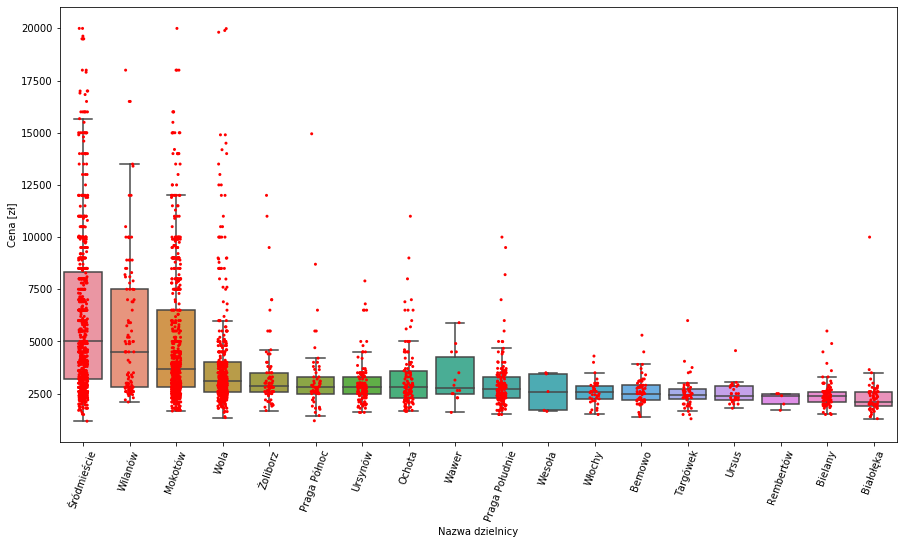

In [697]:
#df = apartaments[apartaments['Powierzchnia'] <= 60]
df = apartaments[apartaments['Cena rzeczywista'] <= 20000]

order = df.groupby('Nazwa dzielnicy')['Cena rzeczywista'].describe()['50%'].sort_values(ascending=False)

plt.figure(figsize=(15,8))
sns.stripplot(data=df, x='Nazwa dzielnicy', y='Cena rzeczywista', color='r', order=order.index, s=3)
#sns.violinplot(data=df, x='Nazwa dzielnicy', y='Cena rzeczywista', order=order.index, showfliers=False, width=3)
sns.boxplot(data=df, x='Nazwa dzielnicy', y='Cena rzeczywista', order=order.index, showfliers=False)
plt.xticks(rotation=70)
plt.ylabel('Cena [zł]')
#plt.ylim(1000,10000)

## 3.2. Show median price for each district

In [74]:
plot_dict = apartaments.groupby('Numer dzielnicy')['Cena rzeczywista'].describe()['50%']
plot_dict.index = [str(i) for i in range(0,18)]

In [75]:
apartaments.groupby('Nazwa dzielnicy')['Cena rzeczywista'].describe()['50%'].astype('int32').rename('Mediana cen [zł]').sort_values()

Nazwa dzielnicy
Białołęka         2100
Bielany           2400
Rembertów         2400
Ursus             2410
Targówek          2430
Bemowo            2500
Włochy            2575
Wesoła            2600
Praga Południe    2700
Wawer             2775
Ochota            2800
Ursynów           2800
Praga Północ      2810
Żoliborz          2850
Wola              3100
Mokotów           3700
Wilanów           4500
Śródmieście       5300
Name: Mediana cen [zł], dtype: int32

In [76]:
# Create a base map
m_1 = folium.Map(location=[52.2323,21.0000], tiles='cartodbpositron', zoom_start=10)

# Add apartaments to the map
mc = MarkerCluster()
for idx, house in apartaments.iterrows():
    if notNan(house['φ']):
        mc.add_child(Marker([house['φ'], house['λ']], popup=str(house['Cena rzeczywista']) + "zł"))
m_1.add_child(mc)

# Add districts coloured by median price to the map
Choropleth(geo_data=geo.__geo_interface__, 
           data=plot_dict,
           key_on="feature.id", 
           fill_color='YlGnBu', 
           legend_name='Mediana cen [zł]',
          ).add_to(m_1)

# Display the map
embed_map(m_1, 'maps/m_1.html')

In [19]:
apartaments.head()

,Cena,Cena rzeczywista,Kaucja,Powierzchnia,Liczba pokoi,Rodzaj zabudowy,Piętro,Okna,Ogrzewanie,Stan wykończenia,...,λ,Czynsz - dodatkowo,Liczba pięter,Materiał budynku,Rok budowy,Odległość od najbliższej stacji metra,Najbliższa stacja metra,Odległość od centrum,Numer dzielnicy,Nazwa dzielnicy
0,2400,2400,2400.0,48.0,3,blok,2,plastikowe,miejskie,do zamieszkania,...,21.066343,NaN,NaN,NaN,NaN,2.3963,Metro Stadion Narodowy,4.5333,7.0,Praga Południe
1,2400,2900,3000.0,45.0,2,apartamentowiec,2,plastikowe,miejskie,do zamieszkania,...,20.930776,500.0,5.0,cegła,2014.0,0.2076,Metro Młociny,7.9005,5.0,Bielany
2,2600,2600,NaN,40.0,2,apartamentowiec,4,plastikowe,miejskie,do zamieszkania,...,21.044630,NaN,6.0,pustak,2018.0,2.1875,Metro Wierzbno,4.7630,6.0,Mokotów
3,2300,2700,2500.0,54.0,2,blok,1,plastikowe,miejskie,do zamieszkania,...,21.054128,400.0,5.0,NaN,2007.0,1.3607,Metro Trocka,7.2078,10.0,Targówek
4,2950,3300,NaN,54.0,3,blok,3,drewniane,miejskie,do zamieszkania,...,21.082662,350.0,4.0,cegła,2016.0,2.3051,Metro Natolin,10.4301,15.0,Wilanów


## 3.3. Correlate data

In [679]:
df = apartaments.copy().drop(columns=['φ', 'λ', 'Cena', 'Czynsz - dodatkowo', 'Kaucja', 'Numer dzielnicy'])

# Apply relevant conditions

#df = df[df['Odległość od centrum'] > 1]
#df = df[df['Odległość od centrum'] < 20]
df = df[df['Cena rzeczywista'] <= 20000]
#df = df[df['Powierzchnia'] <= 100]
#df = df[df['Nazwa dzielnicy'] == 'Śródmieście']
#df = df[df['Okna'] == 'drewniane']

df = df[df['Liczba pokoi'] != "więcej niż 10"]
df['Liczba pokoi'] = df['Liczba pokoi'].astype('int32')

df.corr()

,Cena rzeczywista,Powierzchnia,Liczba pokoi,Liczba pięter,Rok budowy,Odległość od najbliższej stacji metra,Odległość od centrum
Cena rzeczywista,1.000000,0.818079,0.632374,0.046585,0.024196,-0.091954,-0.163318
Powierzchnia,0.818079,1.000000,0.823490,-0.014483,0.008889,-0.038562,-0.029744
Liczba pokoi,0.632374,0.823490,1.000000,-0.023774,0.017741,-0.012407,0.008859
Liczba pięter,0.046585,-0.014483,-0.023774,1.000000,0.050545,-0.018539,-0.036502
Rok budowy,0.024196,0.008889,0.017741,0.050545,1.000000,0.098413,0.180784
Odległość od najbliższej stacji metra,-0.091954,-0.038562,-0.012407,-0.018539,0.098413,1.000000,0.874735
Odległość od centrum,-0.163318,-0.029744,0.008859,-0.036502,0.180784,0.874735,1.000000


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]),
 <a list of 29 Text xticklabel objects>)

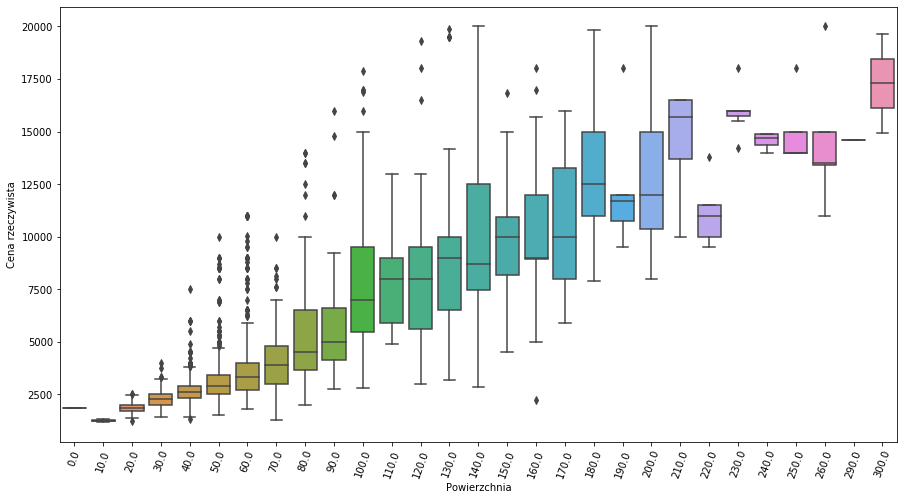

In [687]:
plt.figure(figsize=(15,8))
sns.boxplot('Powierzchnia', 'Cena rzeczywista', data=df.apply
           (lambda x: round(x/10)*10 if x.name == 'Powierzchnia' else x))
plt.xticks(rotation=70)
#plt.ylim(0, 7500)

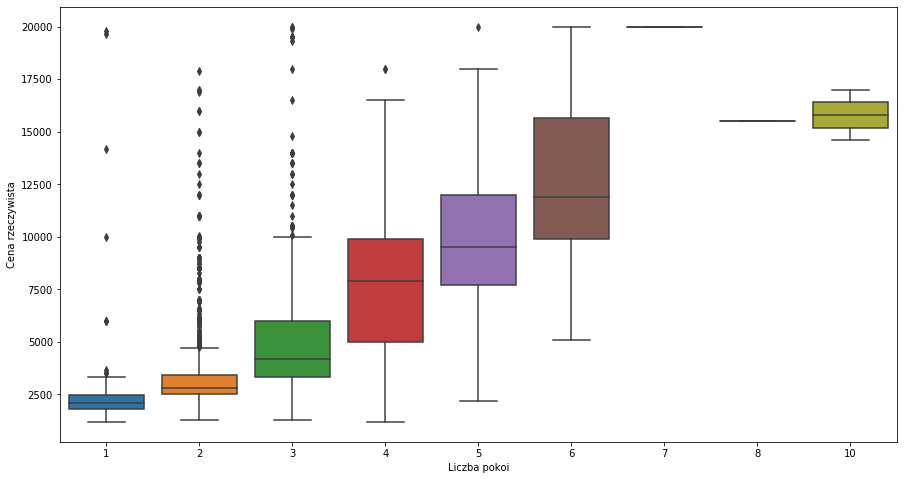

In [688]:
plt.figure(figsize=(15,8))
sns.boxplot('Liczba pokoi', 'Cena rzeczywista', data=df)
#plt.ylim(0, 5000)

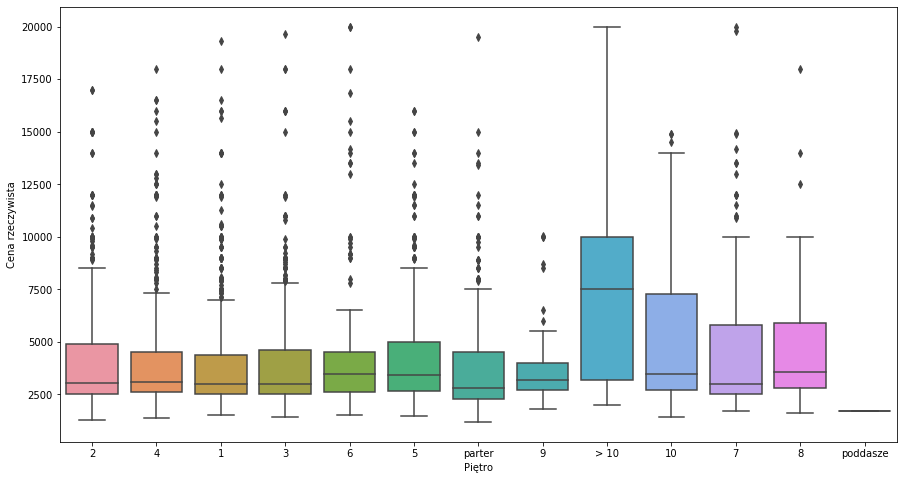

In [698]:
plt.figure(figsize=(15,8))
sns.boxplot('Piętro', 'Cena rzeczywista', data=df)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35]), <a list of 36 Text xticklabel objects>)

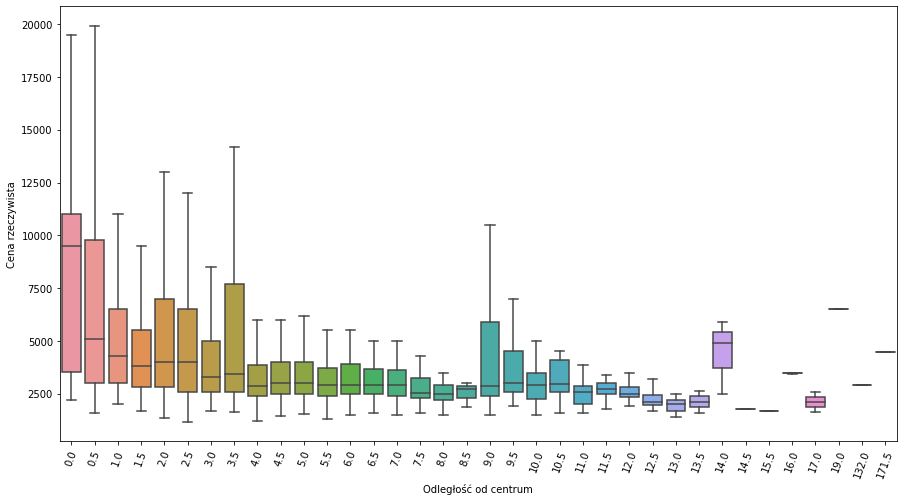

In [683]:
plt.figure(figsize=(15,8))
sns.boxplot('Odległość od centrum', 'Cena rzeczywista', data=df.apply
           (lambda x: round(x/0.5)*0.5 if x.name == 'Odległość od centrum' else x), showfliers=False)
plt.xticks(rotation=70)
#plt.ylim(1000, 5000)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]),
 <a list of 29 Text xticklabel objects>)

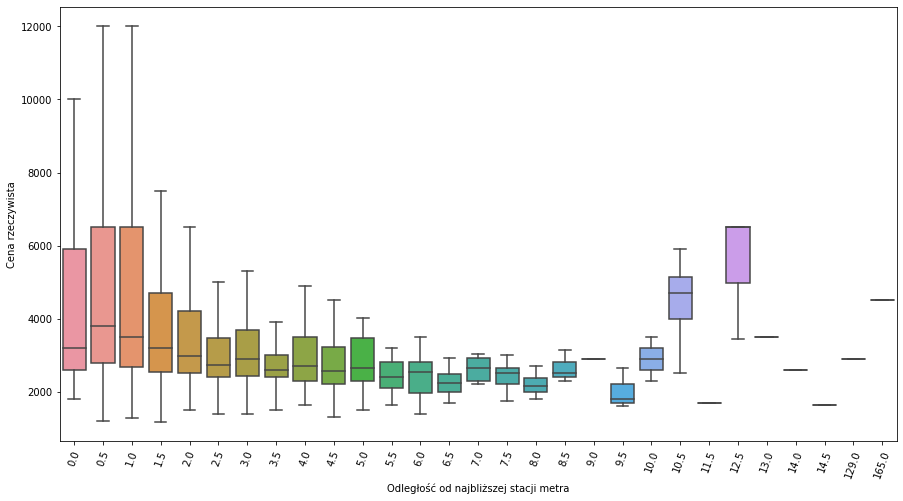

In [684]:
plt.figure(figsize=(15,8))
sns.boxplot('Odległość od najbliższej stacji metra', 'Cena rzeczywista', data=df.apply
           (lambda x: round(x/0.5)*0.5 if x.name == 'Odległość od najbliższej stacji metra' else x), showfliers=False)
plt.xticks(rotation=70)
#plt.ylim(1000, 7500)

Text(0, 0.5, 'Odległość od centrum [km]')

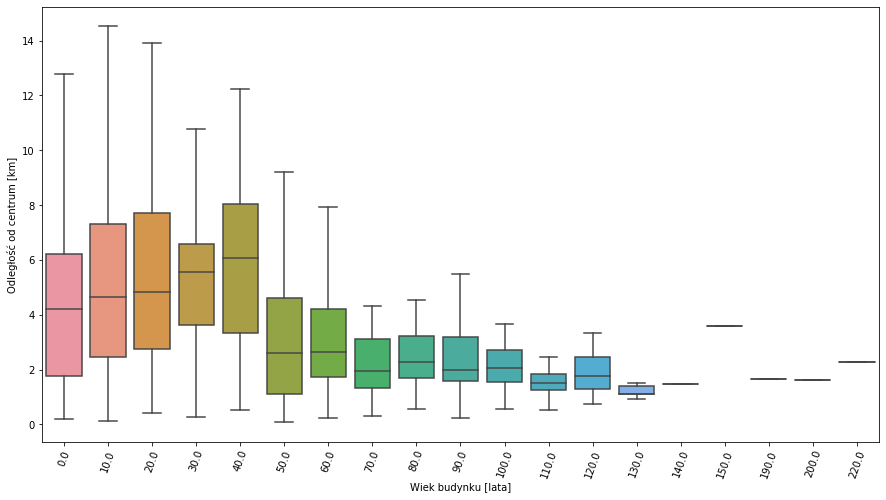

In [685]:
plt.figure(figsize=(15,8))
sns.boxplot('Rok budowy', 'Odległość od centrum', data=df.apply
           (lambda x: round((2019-x)/10)*10 if x.name == 'Rok budowy' else x), showfliers=False)
plt.xticks(rotation=70)
#plt.ylim(0,15)
plt.xlabel('Wiek budynku [lata]')
plt.ylabel('Odległość od centrum [km]')

Text(0, 0.5, 'Cena [zł]')

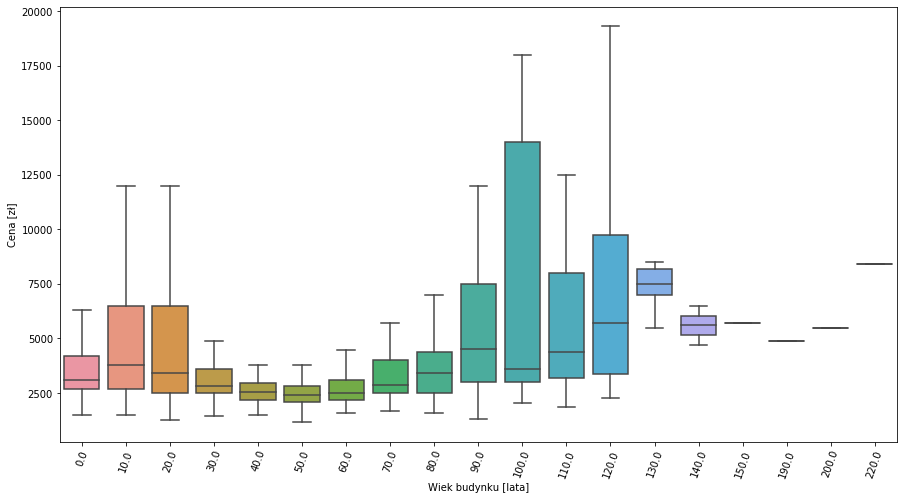

In [686]:
plt.figure(figsize=(15,8))
sns.boxplot('Rok budowy', 'Cena rzeczywista', data=df.apply
           (lambda x: round((2019-x)/10)*10 if x.name == 'Rok budowy' else x), showfliers=False)
plt.xticks(rotation=70)
#plt.ylim(0,15)
plt.xlabel('Wiek budynku [lata]')
plt.ylabel('Cena [zł]')

## Comments:
- `price` and `area of house` relation is `strongly linear`
- `price` and `number of rooms` relation is `strongly linear`
- there is `no relation` between `price` and `floor number`
- there is `some correlation` between `price` and `distance to city center`, aswell as between `nearest metro station location` and `price`. Noticably, there is a peak of price at a distance `~9 km` from city center. It's because exactly in `9 km` there is district `Wilanów`, which is a rich quarter of Warsaw and its prices are not connected with commutation. Peaks at `10.5 km` and `12.5 km` at `nearest metro station location` plot are caused by single houses at district `Wawer` and can be ignored.
- analysing `building's age` and `distance from city center` leads to conclusion, that Warsaw was destroyed in WWII and is being rebuilded starting from city center to `outside direction`
- from `price` vs `building's age` plot we see that the minimum price is for `age = 50 years` (buildings build at year 1970). New buldings aswell as very old buldings are `worth the most`.

# 3.4. Distribution of apartment's floor level

Text(0, 0.5, 'Ilość mieszkań')

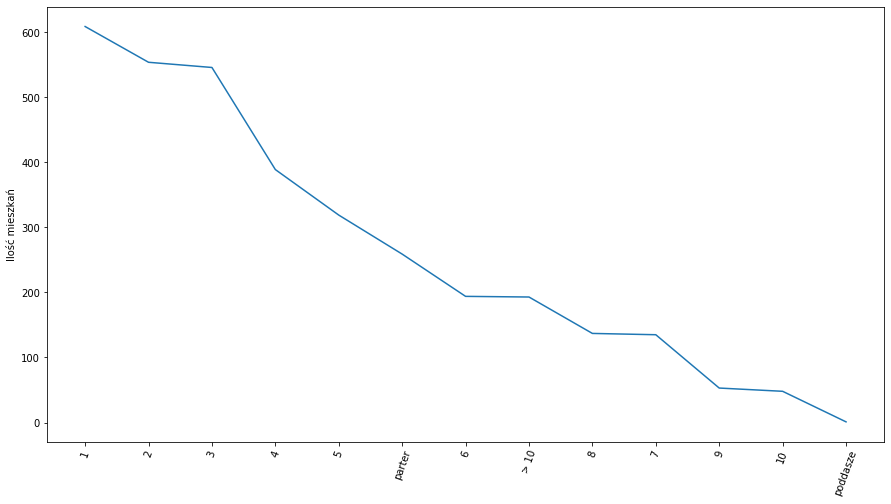

In [28]:
plt.figure(figsize=(15,8))
plt.plot(apartaments['Piętro'].value_counts())
plt.xticks(rotation=70)
plt.ylabel('Ilość mieszkań')

## Comment:
Most apartaments are suprisingly located not on the `groud floor` (parter), but rather on 1st, 2nd or 3rd floor.

# 4. Prediction

## 4.1. Linear regressor and support vector mashines

In [29]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR

In [855]:
df = apartaments.copy()
df = df[df['Cena rzeczywista'] <= 4000]  # Predict for prices below 4000 zł for more acc in this range
#df = df[df['Powierzchnia'] <= 100]

def Encode(df):
    for column in df.columns[df.columns.isin(['Okna', 'Nazwa dzielnicy', 'Liczba pokoi'])]:
        df[column] = df[column].factorize()[0]
    return df

X = ['Powierzchnia', 'Liczba pokoi', 'φ', 'λ', 'Rok budowy']#, 'Nazwa dzielnicy'])  #, 'Odległość od najbliższej stacji metra', 'Odległość od centrum',])
Y = ['Cena rzeczywista']

df = df[X + Y].dropna()

x = Encode(df[X].copy())
y = df[Y]

In [856]:
display(df[X].copy().head())
display(Encode(df[X].copy()).head())

,Powierzchnia,Liczba pokoi,φ,λ,Rok budowy
1,45.0,2,52.289194,20.930776,2014.0
2,40.0,2,52.199425,21.044630,2018.0
3,54.0,2,52.287912,21.054128,2007.0
4,54.0,3,52.153523,21.082662,2016.0
10,44.0,2,52.187521,21.005663,2016.0


,Powierzchnia,Liczba pokoi,φ,λ,Rok budowy
1,45.0,0,52.289194,20.930776,2014.0
2,40.0,0,52.199425,21.044630,2018.0
3,54.0,0,52.287912,21.054128,2007.0
4,54.0,1,52.153523,21.082662,2016.0
10,44.0,0,52.187521,21.005663,2016.0


In [857]:
x_train, x_test, y_train, y_test = train_test_split( x, y, test_size=0.33, random_state = 324)

In [858]:
scaler_x = StandardScaler().fit(x_train)
x_train = scaler_x.transform(x_train)
x_test = scaler_x.transform(x_test)

In [859]:
regressor = SVR(C=10000, gamma=0.1) 
#regressor = LinearRegression()
regressor.fit(x_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:744: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVR(C=10000, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma=0.1,
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [860]:
print(x_train.shape, x_test.shape)

(996, 5) (491, 5)


Mean square error is 347.7349881419741
R^2 score is 0.6434315414983812


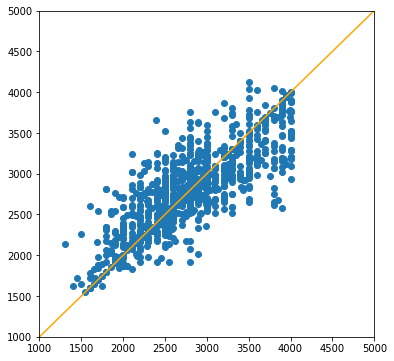

In [861]:
plt.figure(figsize=(6,6))
y_pred = regressor.predict(x_train)
plt.scatter(y_train, y_pred)

plt.xlim(1000, 5000)
plt.ylim(1000, 5000)
plt.plot([1000, 20000], [1000, 20000], color='orange')

mse = np.sqrt(mean_squared_error(y_true=y_train, y_pred=y_pred))
r2 = r2_score(y_train, y_pred)
print("Mean square error is {}\nR^2 score is {}".format(mse, r2))

Mean square error is 374.3780150088413
R^2 score is 0.603162948672441


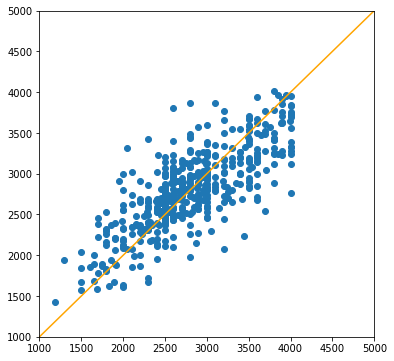

In [862]:
plt.figure(figsize=(6,6))
y_pred = regressor.predict(x_test)
plt.scatter(y_test, y_pred)

plt.xlim(1000, 5000)
plt.ylim(1000, 5000)
plt.plot([1000, 20000], [1000, 20000], color='orange')

mse = np.sqrt(mean_squared_error(y_true=y_test, y_pred=y_pred))
r2 = r2_score(y_test, y_pred)
print("Mean square error is {}\nR^2 score is {}".format(mse, r2))

## Test on some hand-typed data

In [802]:
test = pd.DataFrame([[21.109, 0, 52.23205, 2015, 50]], columns=['λ', 'Liczba pokoi', 'φ', 'Rok budowy', 'Powierzchnia'])
test = scaler_x.transform(test)
regressor.predict(test)

array([2650.65035758])

## 4.2. Neural Network (works badly for small price ranges)

In [716]:
import keras
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import r2_score

In [717]:
x_train_ = np.expand_dims(x_train, axis=2)
x_test_ = np.expand_dims(x_test, axis=2)

In [718]:
x.shape

(1487, 5)

In [719]:
# define regression model
def regression_model():
    # create model
    model = Sequential()
    model.add(Dense(500, activation='relu', input_shape=(x.shape[1],)))
    model.add(Dense(500, activation='relu'))
    model.add(Dense(500, activation='relu'))
    model.add(Dense(1))
    
    # compile model
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model


model = regression_model()
model.fit(x_train, y_train, validation_split=0.2, epochs=100, verbose=0)

0.6090891846071345

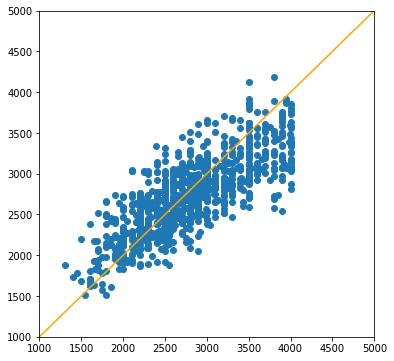

In [720]:
plt.figure(figsize=(6,6))
y_pred = model.predict(x_train)
plt.scatter(y_train, y_pred)

plt.xlim(1000, 5000)
plt.ylim(1000, 5000)
plt.plot([1000, 20000], [1000, 20000], color='orange')

#print(np.sqrt(mean_squared_error(y_true=y_train, y_pred=y_pred)))
r2_score(y_train, y_pred)

0.5962662002002623

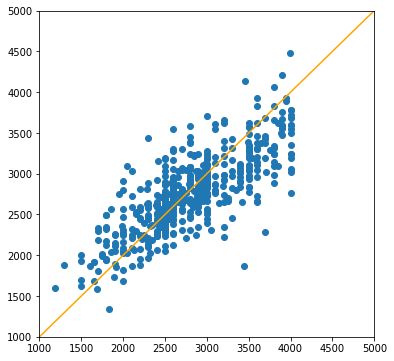

In [721]:
plt.figure(figsize=(6,6))
y_pred = model.predict(x_test)
plt.scatter(y_test, y_pred)

plt.xlim(1000, 5000)
plt.ylim(1000, 5000)
plt.plot([1000, 20000], [1000, 20000], color='orange')

#print(np.sqrt(mean_squared_error(y_true=y_test, y_pred=y_pred)))
r2_score(y_test, y_pred)